In [1]:
#import libraries
import numpy as np
import pandas as pd

from itertools import product
#matplot.lb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn import *
import time



from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop


F:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
F:\Anaconda3\lib\site-packages\h5py\_

In [2]:
#read files

items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_cats = pd.read_csv('item_categories.csv')

#train and test
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv').set_index('ID')

print(len(train))

2935849


In [3]:
#checking if all shop and items in the test are also in training
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [4]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

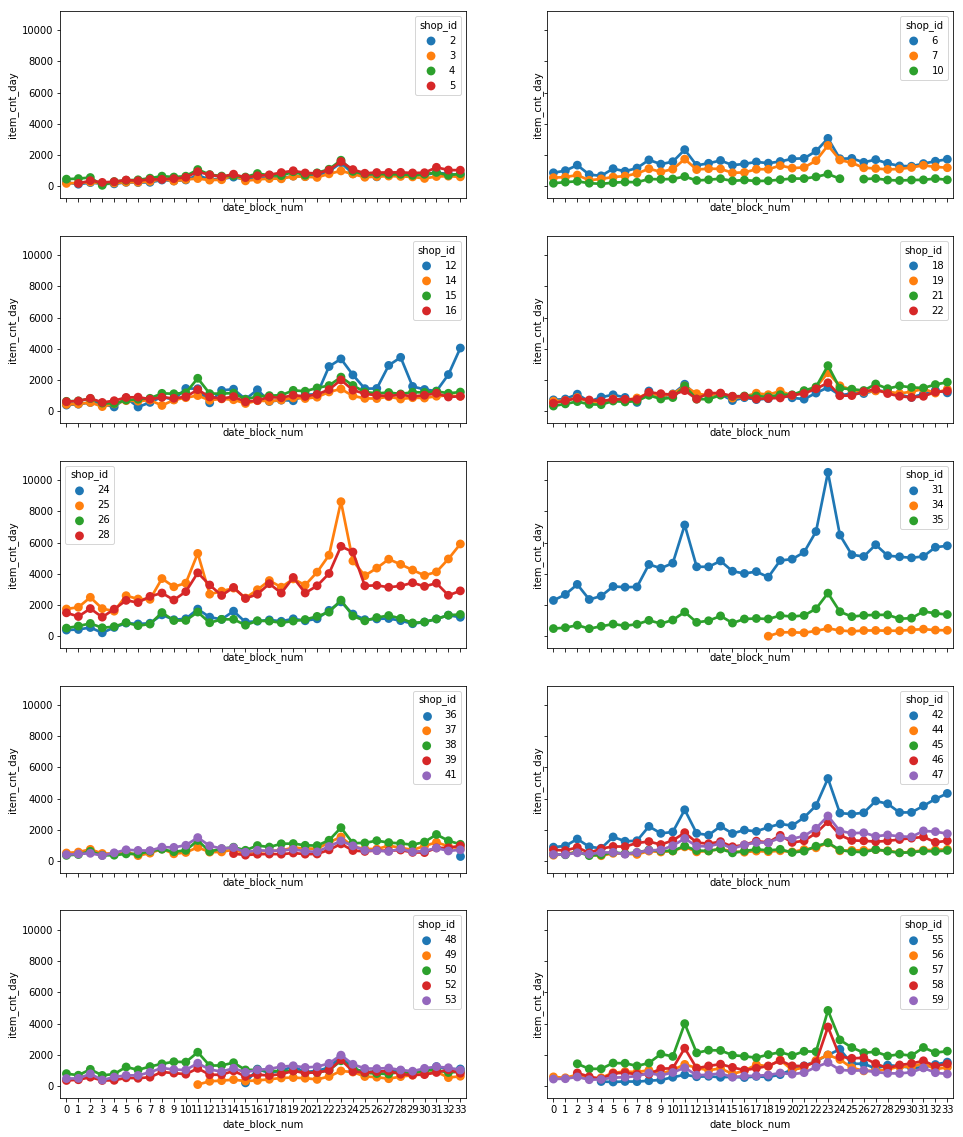

In [5]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0


for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [6]:
grouped

,shop_id,date_block_num,item_cnt_day
0,2,0,248.0
1,2,1,135.0
2,2,2,237.0
3,2,3,168.0
4,2,4,159.0
5,2,5,255.0
6,2,6,242.0
7,2,7,257.0
8,2,8,403.0
9,2,9,345.0


In [7]:
# add categories
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [8]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

train['year']

0          2013
1          2013
2          2013
3          2013
4          2013
5          2013
6          2013
7          2013
8          2013
9          2013
10         2013
11         2013
12         2013
13         2013
14         2013
15         2013
16         2013
17         2013
18         2013
19         2013
20         2013
21         2013
22         2013
23         2013
24         2013
25         2013
26         2013
27         2013
28         2013
29         2013
           ... 
1224409    2015
1224410    2015
1224411    2015
1224412    2015
1224413    2015
1224414    2015
1224415    2015
1224416    2015
1224417    2015
1224418    2015
1224419    2015
1224420    2015
1224421    2015
1224422    2015
1224423    2015
1224424    2015
1224425    2015
1224426    2015
1224427    2015
1224428    2015
1224429    2015
1224430    2015
1224431    2015
1224432    2015
1224433    2015
1224434    2015
1224435    2015
1224436    2015
1224437    2015
1224438    2015
Name: year, Length: 1224

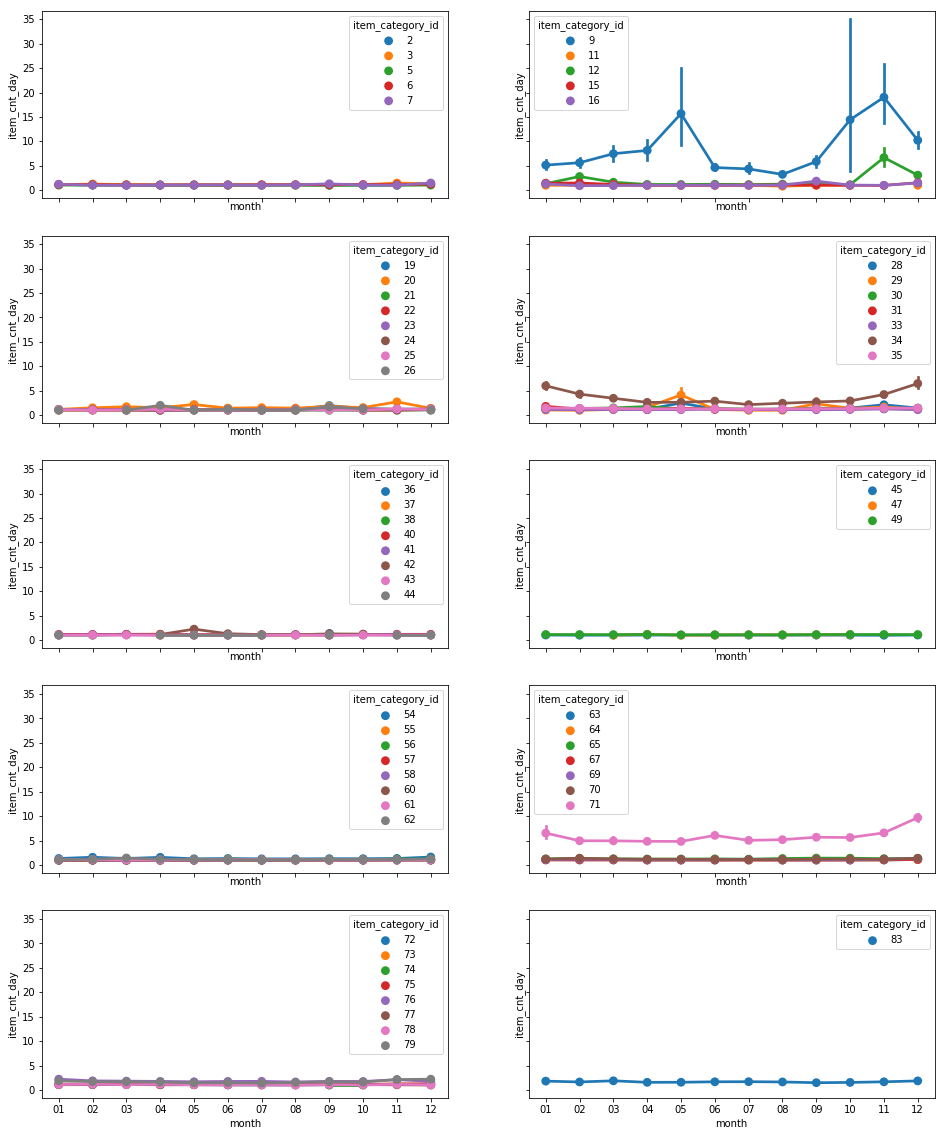

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

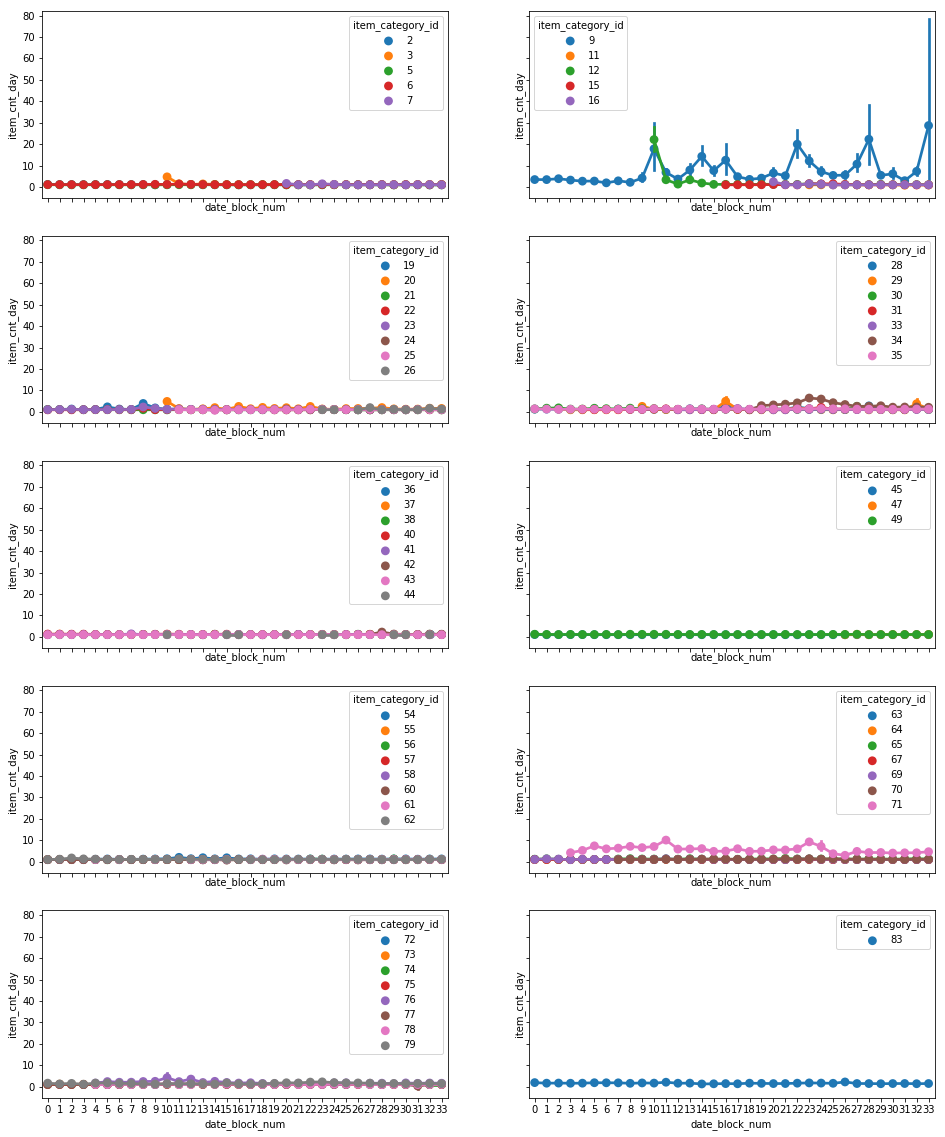

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [11]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

In [12]:
train.item_price.as_matrix()

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([359., 399., 169., ..., 299., 598., 299.])

In [13]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.as_matrix().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.as_matrix().reshape(-1, 1))

print(train.item_price)
print(train.item_cnt_day)

shop_id  item_id  date_block_num  month  year
2        30       2               03     2013   -0.248665
                  5               06     2013   -0.242961
                  15              04     2014   -0.275760
                  16              05     2014   -0.275760
         31       1               02     2013    0.098859
                  2               03     2013   -0.200251
                  3               04     2013   -0.200180
                  16              05     2014   -0.240548
                  33              10     2015   -0.242961
         32       12              01     2014   -0.282890
                  14              03     2014   -0.278612
                  18              07     2014   -0.278612
                  20              09     2014   -0.257364
                  21              10     2014   -0.257364
                  23              12     2014   -0.257364
                  26              03     2015   -0.278612
                  31      

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [14]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30      1              3         -0.072265      0.115543
                       4          0.041532      0.381274
                       5         -0.072265      0.204120
                       6          0.314142      2.241392
                       7          0.149626      0.647005
                       10        -0.186490      0.115543
                       12        -0.242961     -0.150189
                       14         0.149626      0.469851
                       15         0.208426      1.178467
                       16         0.097005      1.178467
                       18        -0.072265      0.292697
                       19         0.152478      1.089890
                       21         0.098431      0.912736
                       22         0.041532      0.558428
                       24         0.326026      1.089890
                       25         0.439823      4.012933
                       26         0.316329      1.709929
                       28         0.661704      4.987280
                       31         0.665965      9.681864
                       35         0.142971      1.178467
                       37         0.212228      1.089890
                       38         0.098431      0.469851
                       41        -0.186062     -0.061612
                       42         0.548283      3.835779
                       44         0.269127      1.355621
                       45        -0.015366      0.292697
                       46         0.382925      1.621352
                       47         0.089854      0.647005
                       50         0.494821      2.329969
                       52        -0.129164      0.204120
...                                    ...           ...
22167   30             52        -0.214583     -0.061612
        31             2         -0.257221     -0.150189
                       12        -0.129306      0.115543
                       22         0.041247      0.912736
                       25        -0.214583     -0.061612
                       26        -0.257221     -0.150189
                       31        -0.257221     -0.150189
                       35        -0.257221     -0.150189
                       39        -0.257221     -0.150189
                       42        -0.171945      0.026965
                       52        -0.214583     -0.061612
        32             12        -0.044030      0.292697
                       21        -0.214583     -0.061612
                       22        -0.129306      0.115543
                       24        -0.257221     -0.150189
                       25        -0.129306      0.115543
                       42        -0.171945      0.115543
        33             6         -0.257221     -0.150189
                       10        -0.277756     -0.150189
                       12        -0.001391      0.381274
                       18        -0.257221     -0.150189
                       21        -0.257221     -0.150189
                       22         0.162767      1.001313
                       25        -0.214583      0.026965
                       26        -0.257221     -0.150189
                       28        -0.257221     -0.150189
                       37        -0.257221     -0.150189
                       42        -0.171945      0.115543
                       47        -0.257221     -0.150189
                       50        -0.257221     -0.150189

[600159 rows x 2 columns]

In [15]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [16]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [17]:
assert closest_date_block(18, 30, 5) == 18

In [18]:
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


In [19]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [20]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [21]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

In [22]:
from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

#cat_le = preprocessing.LabelEncoder()
#cat_le.fit(item_cats.item_category_id)
#cat_dm = dict(zip(item_cats.item_category_id.unique(), cat_le.transform(item_cats.item_category_id.unique())))

In [23]:
def vectorize(inp):
    print('Vectorization...')   
    x = np.zeros((len(inp), maxlen, length), dtype=np.float16)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [25]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

Vectorization...


MemoryError: 

In [26]:
x_train

array([[[ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2429 ,
          0.     ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2429 ,
          0.     ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2429 ,
          0.     ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.276  ,
         -0.1501 ]],

       [[ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2002 ,
         -0.1501 ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2002 ,
          0.     ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2002 ,
          0.     ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2002 ,
          0.     ]],

       [[ 0.     ,  0.     ,  0.     , ...,  0.     , -0.25   ,
         -0.1501 ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2003 ,
         -0.0616 ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2003 ,
          0.     ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     , -0.2003 ,
        

In [27]:
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))


Build model...


In [28]:
optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

Epoch 1/13
111404/111404 [==============================] - 87s 783us/step - loss: 0.0885
Epoch 2/13
111404/111404 [==============================] - 81s 724us/step - loss: 0.0764
Epoch 3/13
111404/111404 [==============================] - 67s 601us/step - loss: 0.0676
Epoch 4/13
111404/111404 [==============================] - 63s 562us/step - loss: 0.0598
Epoch 5/13
111404/111404 [==============================] - 63s 570us/step - loss: 0.0546
Epoch 6/13
111404/111404 [==============================] - 61s 549us/step - loss: 0.0510
Epoch 7/13
111404/111404 [==============================] - 59s 529us/step - loss: 0.0430
Epoch 8/13
111404/111404 [==============================] - 61s 545us/step - loss: 0.0489
Epoch 9/13
111404/111404 [==============================] - 63s 567us/step - loss: 0.0563
Epoch 10/13
111404/111404 [==============================] - 66s 591us/step - loss: 0.0459
Epoch 11/13
111404/111404 [==============================] - 65s 584us/step - loss: 0.0457
Epoch 12

In [29]:
model.fit(x_val, y_val, batch_size=128, epochs=13)

Epoch 1/13
111404/111404 [==============================] - 72s 643us/step - loss: 0.0099
Epoch 2/13
111404/111404 [==============================] - 63s 566us/step - loss: 0.0101
Epoch 3/13
111404/111404 [==============================] - 59s 531us/step - loss: 0.0082
Epoch 4/13
111404/111404 [==============================] - 66s 589us/step - loss: 0.0098
Epoch 5/13
111404/111404 [==============================] - 64s 572us/step - loss: 0.0116
Epoch 6/13
111404/111404 [==============================] - 65s 588us/step - loss: 0.0100
Epoch 7/13
111404/111404 [==============================] - 67s 598us/step - loss: 0.0095
Epoch 8/13
111404/111404 [==============================] - 64s 575us/step - loss: 0.0079
Epoch 9/13
111404/111404 [==============================] - 66s 590us/step - loss: 0.0076
Epoch 10/13
111404/111404 [==============================] - 66s 590us/step - loss: 0.0077
Epoch 11/13
111404/111404 [==============================] - 62s 560us/step - loss: 0.0059
Epoch 12

In [30]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

NameError: name 'x_test' is not defined

In [ ]:
test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

In [ ]:
for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

In [ ]:
test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('final_sub.csv', index=False)